2D linear elasticity example
Solve the equilibrium equation $ -\nabla \cdot \sigma(x) = f(x) \mbox { for } x\in\Omega $
with the strain-displacement equation:
    \begin{equation} \epsilon = 1/2(\nabla u + \nabla u^T) \end{equation}
and the constitutive law:
    \begin{equation} \sigma = 2*\mu*\epsilon + \lambda*(\nabla\cdot u)I, \end{equation}
where $\mu$ and $\lambda$ are Lam\'e constants, $I$ is the identity tensor.
Dirichlet boundary conditions: $ u(x)=\hat{u} \mbox{ for } x\in\Gamma_D $
Neumann boundary conditions: $ \sigma n = \hat{t} \mbox { for } x\in \Gamma_N, $
where n is the normal vector.
For this example:
    $\Omega$ is a rectangle with corners at  (0,0) and (8,2)
   Dirichlet boundary conditions for $x=0$:
           \begin{equation} u(x,y) = P/(6*E*I)*y*((2+nu)*(y^2-W^2/4)) \end{equation}
           \begin{equation} v(x,y) = -P/(6*E*I)*(3*nu*y^2*L)  \end{equation}
    and parabolic traction at $x=8 $
           \begin{equation} p(x,y) = P*(y^2 - y*W)/(2*I) \end{equation}
    where $P=2$ is the maxmimum traction
         $E = 1e3$ is Young's modulus  
          $\nu = 0.25$ is the Poisson ratio  
          $I = W^3/12$ is second moment of area of the cross-section


In [1]:
import tensorflow as tf
import numpy as np
import time
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import scipy.optimize
import sys
sys.path.append('..')
from utils.tfp_loss import tfp_function_factory
from utils.scipy_loss import scipy_function_factory
from utils.Geom_examples import Quadrilateral
from utils.Solvers import Elasticity2D_coll_dist
from utils.Plotting import plot_pts, plot_convergence_semilog
#make figures bigger on HiDPI monitors
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
class Elast_TimoshenkoBeam(Elasticity2D_coll_dist):
    '''
    Class including the boundary conditions for the Timoshenko beam problem
    '''       
    def __init__(self, layers, train_op, num_epoch, print_epoch, model_data, data_type):        
        super().__init__(layers, train_op, num_epoch, print_epoch, model_data, data_type)
       
    @tf.function
    def dirichletBound(self, X, xPhys, yPhys):    
        # multiply by x,y for strong imposition of boundary conditions
        u_val = X[:,0:1]
        v_val = X[:,1:2]
        self.W = 2.0
        self.L = 8.0
        self.I = self.W**3/12
        self.P = 2.0
        self.pei = self.P/(6*self.Emod*self.I)

        y_temp = yPhys - self.W/2    
        u_left = self.pei*y_temp*((2+self.nu)*(y_temp**2-self.W**2/4));
        v_left =-self.pei*(3*self.nu*y_temp**2*self.L);
        
        u_val = xPhys*u_val + u_left
        v_val = xPhys*v_val + v_left
        
        return u_val, v_val

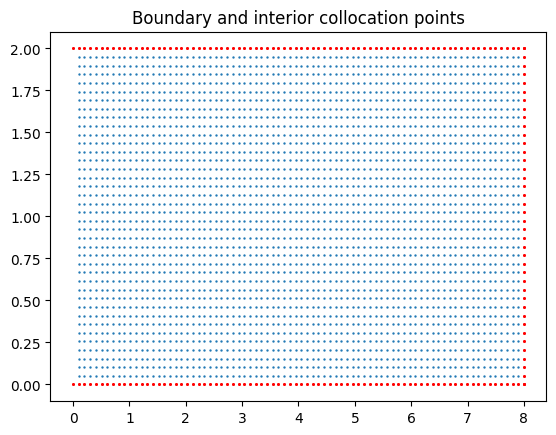

In [5]:
#define the input and output data set
beam_length = 8.
beam_width = 2.
domainCorners = np.array([[0., 0.], [0, beam_width], [beam_length, 0.], [beam_length, beam_width]])
geomDomain = Quadrilateral(domainCorners)

numPtsU = 80
numPtsV = 40
#xPhys, yPhys = myQuad.getRandomIntPts(numPtsU*numPtsV)
xPhys, yPhys = geomDomain.getUnifIntPts(numPtsU,numPtsV,[0,0,0,0])
data_type = "float64"

Xint = np.concatenate((xPhys,yPhys),axis=1).astype(data_type)
Yint = np.zeros_like(Xint).astype(data_type)

# prepare boundary points in the fromat Xbnd = [Xcoord, Ycoord, dir] and
# Ybnd = [trac], where Xcoord, Ycoord are the x and y coordinate of the point,
# dir=0 for the x-component of the traction and dir=1 for the y-component of 
# the traction
               
#bottom boundary, include both x and y directions
xPhysBndB, yPhysBndB, xNormB, yNormB = geomDomain.getUnifEdgePts(numPtsU, numPtsV, [1,0,0,0])
dirB0 = np.zeros_like(xPhysBndB)
dirB1 = np.ones_like(xPhysBndB)
XbndB0 = np.concatenate((xPhysBndB, yPhysBndB, xNormB, yNormB, dirB0), axis=1).astype(data_type)
XbndB1 = np.concatenate((xPhysBndB, yPhysBndB, xNormB, yNormB, dirB1), axis=1).astype(data_type)

#boundary for x=beam_length, include both the x and y directions
xPhysBndC, yPhysBndC, xNormC, yNormC = geomDomain.getUnifEdgePts(numPtsU, numPtsV, [0,1,0,0])
dirC0 = np.zeros_like(xPhysBndC)
dirC1 = np.ones_like(xPhysBndC)
XbndC0 = np.concatenate((xPhysBndC, yPhysBndC, xNormC, yNormC, dirC0), axis=1).astype(data_type)
XbndC1 = np.concatenate((xPhysBndC, yPhysBndC, xNormC, yNormC, dirC1), axis=1).astype(data_type)

#boundary for y=beam_width, include both the x and y direction
xPhysBndD, yPhysBndD, xNormD, yNormD = geomDomain.getUnifEdgePts(numPtsU, numPtsV, [0,0,1,0])
dirD0 = np.zeros_like(xPhysBndD)
dirD1 = np.ones_like(xPhysBndD)
XbndD0 = np.concatenate((xPhysBndD, yPhysBndD, xNormD, yNormD, dirD0), axis=1).astype(data_type)
XbndD1 = np.concatenate((xPhysBndD, yPhysBndD, xNormD, yNormD, dirD1), axis=1).astype(data_type)

# concatenate all the boundaries
Xbnd = np.concatenate((XbndB0, XbndB1, XbndC0, XbndC1, XbndD0, XbndD1), axis=0)

#plot the collocation points
plot_pts(Xint, Xbnd[:,0:2])

model_data = dict()
model_data["E"] = 1e3
model_data["nu"] = 0.25
model_data["state"] = "plane stress"

#define loading
pressure = 2.
YbndB0 = np.zeros_like(xPhysBndB).astype(data_type)
YbndB1 = np.zeros_like(xPhysBndB).astype(data_type)
YbndC0 = np.zeros_like(xPhysBndC).astype(data_type)
inert = beam_width**3/12
YbndC1 = (pressure*(yPhysBndC**2 - yPhysBndC*beam_width)/(2*inert)).astype(data_type)
    
YbndD0 = np.zeros_like(xPhysBndD).astype(data_type)
YbndD1 = np.zeros_like(xPhysBndD).astype(data_type)
Ybnd = np.concatenate((YbndB0, YbndB1, YbndC0, YbndC1, YbndD0, YbndD1), axis=0)

In [6]:
#define the model 
tf.keras.backend.set_floatx(data_type)
l1 = tf.keras.layers.Dense(20, "swish")         
l2 = tf.keras.layers.Dense(20, "swish")          
l3 = tf.keras.layers.Dense(20, "swish")           
l4 = tf.keras.layers.Dense(2, None)
train_op = tf.keras.optimizers.Adam()
train_op2 = "TFP-BFGS"
num_epoch = 1000
print_epoch = 100
pred_model = Elast_TimoshenkoBeam([l1, l2, l3, l4], train_op, num_epoch, 
                                    print_epoch, model_data, data_type)

#convert the training data to tensors
Xint_tf = tf.convert_to_tensor(Xint)
Yint_tf = tf.convert_to_tensor(Yint)
Xbnd_tf = tf.convert_to_tensor(Xbnd)
Ybnd_tf = tf.convert_to_tensor(Ybnd)

In [7]:
#training
t0 = time.time()
print("Training (ADAM)...")

pred_model.network_learn(Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf   )
t1 = time.time()
print("Time taken (ADAM)", t1-t0, "seconds")

if train_op2=="SciPy-LBFGS-B":
    print("Training (SciPy-LBFGS-B)...")
    loss_func = scipy_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf)
    init_params = np.float64(tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables).numpy())
    results = scipy.optimize.minimize(fun=loss_func, x0=init_params, jac=True, method='L-BFGS-B',
                options={'disp': None, 'maxls': 50, 'iprint': -1, 
                'gtol': 1e-6, 'eps': 1e-6, 'maxiter': 50000, 'ftol': 1e-6, 
                'maxcor': 50, 'maxfun': 50000})
    # after training, the final optimized parameters are still in results.position
    # so we have to manually put them back to the model
    loss_func.assign_new_model_parameters(results.x)
else:            
    print("Training (TFP-BFGS)...")

    loss_func = tfp_function_factory(pred_model, Xint_tf, Yint_tf, Xbnd_tf, Ybnd_tf)
    # convert initial model parameters to a 1D tf.Tensor
    init_params = tf.dynamic_stitch(loss_func.idx, pred_model.trainable_variables)
    # train the model with L-BFGS solver
    results = tfp.optimizer.bfgs_minimize(
        value_and_gradients_function=loss_func, initial_position=init_params,
              max_iterations=1000, tolerance=1e-6)  
    # after training, the final optimized parameters are still in results.position
    # so we have to manually put them back to the model
    loss_func.assign_new_model_parameters(results.position)    
t2 = time.time()
print("Time taken (BFGS)", t2-t1, "seconds")
print("Time taken (all)", t2-t0, "seconds")

Training (ADAM)...
Epoch 0 loss: 192607.47655512614, int_loss_x: 16668.886792179048, int_loss_y: 36976.48515768005
Epoch 100 loss: 164.2879732032476, int_loss_x: 26.585393879450795, int_loss_y: 9.436993396369143
Epoch 200 loss: 62.407424111936365, int_loss_x: 7.3170109387714755, int_loss_y: 4.249965619507291
Epoch 300 loss: 35.986037337011894, int_loss_x: 5.77814568501904, int_loss_y: 1.7833649614014333
Epoch 400 loss: 27.114316917082828, int_loss_x: 5.3141006702310625, int_loss_y: 1.5569725355429045
Epoch 500 loss: 21.829998821592802, int_loss_x: 4.785177180936232, int_loss_y: 1.6435472290237334
Epoch 600 loss: 17.780871918521584, int_loss_x: 4.215432174796663, int_loss_y: 1.6653916581973625
Epoch 700 loss: 14.60802853038404, int_loss_x: 3.6655106401994515, int_loss_y: 1.6274769840818943
Epoch 800 loss: 12.156956198288505, int_loss_x: 3.1704045113754273, int_loss_y: 1.5553736743569833
Epoch 900 loss: 10.285035650448648, int_loss_x: 2.7409022401052714, int_loss_y: 1.4618568890471293
Ti

In [6]:
#define the exact displacements
def exact_disp(x,y):
    E = model_data["E"]
    nu = model_data["nu"]
    inert=beam_width**3/12;
    pei=pressure/(6*E*inert)
    y_temp = y - beam_width/2  #move (0,0) to below left corner     
    x_disp = pei*y_temp*((6*beam_length-3*x)*x+(2+nu)*(y_temp**2-beam_width**2/4))
    y_disp =-pei*(3*nu*y_temp**2*(beam_length-x)+(4+5*nu)*beam_width**2*x/4+(3*beam_length-x)*x**2)
    return x_disp, y_disp


Testing...


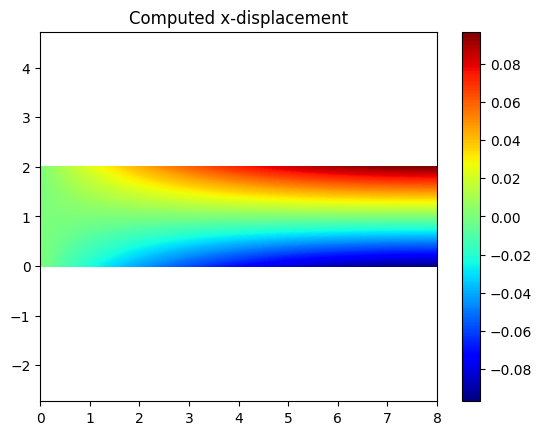

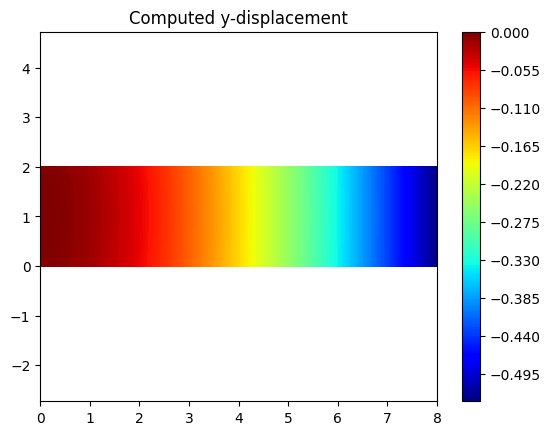

In [7]:
print("Testing...")
numPtsUTest = 2*numPtsU
numPtsVTest = 2*numPtsV
xPhysTest, yPhysTest = geomDomain.getUnifIntPts(numPtsUTest, numPtsVTest, [1,1,1,1])
XTest = np.concatenate((xPhysTest,yPhysTest),axis=1).astype(data_type)
XTest_tf = tf.convert_to_tensor(XTest)
YTest = pred_model(XTest_tf).numpy()        

xPhysTest2D = np.resize(XTest[:,0], [numPtsVTest, numPtsUTest])
yPhysTest2D = np.resize(XTest[:,1], [numPtsVTest, numPtsUTest])
YTest2D_x = np.resize(YTest[:,0], [numPtsVTest, numPtsUTest])
YTest2D_y = np.resize(YTest[:,1], [numPtsVTest, numPtsUTest])

plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_x, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed x-displacement")
plt.axis('equal')
plt.show()

plt.contourf(xPhysTest2D, yPhysTest2D, YTest2D_y, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Computed y-displacement")
plt.axis('equal')
plt.show()    

Relative L2 error:  0.0009149673872105514


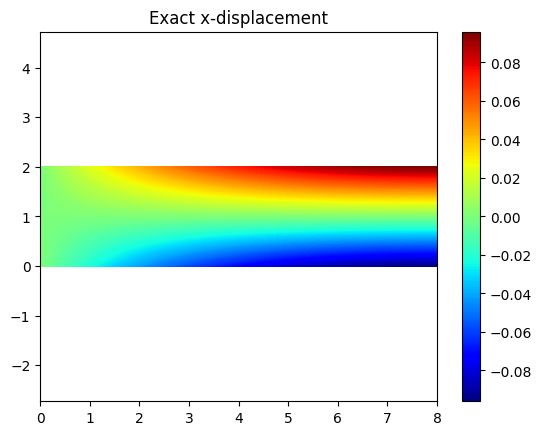

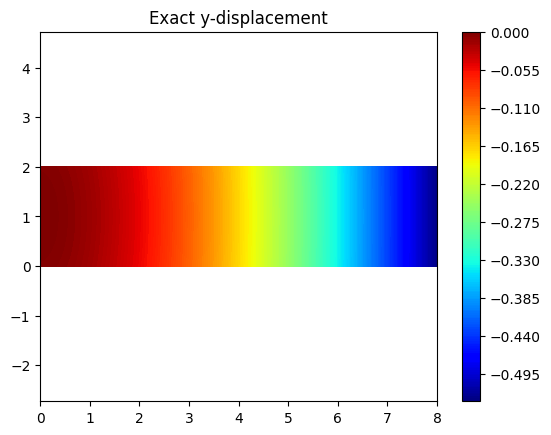

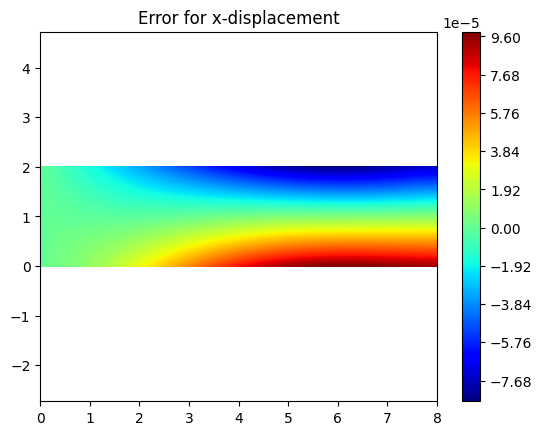

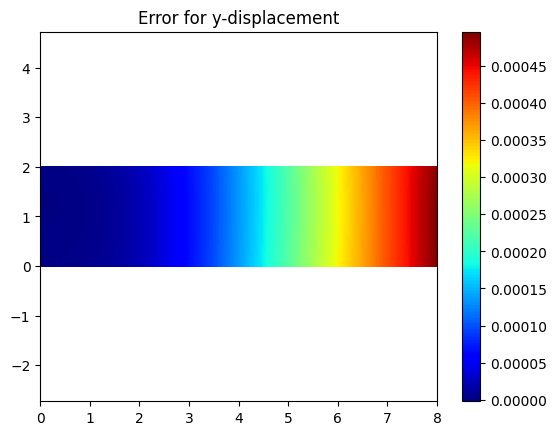

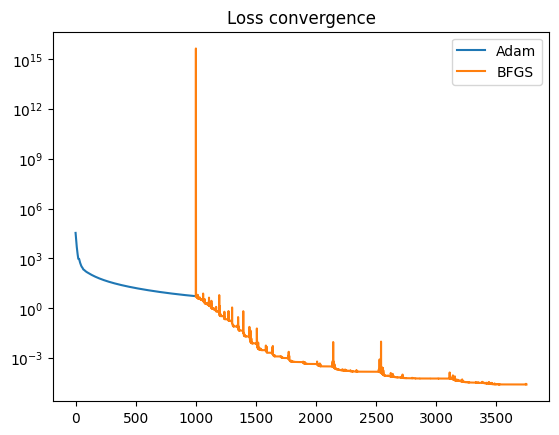

In [8]:
# comparison with exact solution    
ux_exact, uy_exact = exact_disp(xPhysTest, yPhysTest)
ux_test = YTest[:,0:1]    
uy_test = YTest[:,1:2]
err_norm = np.sqrt(np.sum((ux_exact-ux_test)**2+(uy_exact-uy_test)**2))
ex_norm = np.sqrt(np.sum(ux_exact**2 + uy_exact**2))
rel_err_l2 = err_norm/ex_norm
print("Relative L2 error: ", rel_err_l2)

YExact2D_x = np.resize(ux_exact, [numPtsVTest, numPtsUTest])
YExact2D_y = np.resize(uy_exact, [numPtsVTest, numPtsUTest])

plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_x, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Exact x-displacement")
plt.axis('equal')
plt.show()

plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_y, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Exact y-displacement")
plt.axis('equal')
plt.show()

plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_x-YTest2D_x, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Error for x-displacement")
plt.axis('equal')
plt.show()

plt.contourf(xPhysTest2D, yPhysTest2D, YExact2D_y-YTest2D_y, 255, cmap=plt.cm.jet)
plt.colorbar()
plt.title("Error for y-displacement")
plt.axis('equal')
plt.show()           

# plot the loss convergence
plot_convergence_semilog(pred_model.adam_loss_hist, loss_func.history)